# PMT Pulse analysis

Jelle, updated May 2019

Standard python setup:

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# This just ensures some comments in dataframes below display nicely
import pandas as pd
pd.options.display.max_colwidth = 100

After this standard setup, we can load straxen:

In [2]:
import strax
import straxen
st = straxen.contexts.xenon1t_dali()

### Raw records

Let's select a background run from SR1 for which we have strax data.

In [3]:
dsets = st.select_runs(available='raw_records', 
                       include_tags='sciencerun1',
                       run_mode='background_stable')
run_id = dsets.name.min()
run_id

Checking data availability: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


'170204_1410'

This run is one hour long, so the full raw waveform data won't fit into memory. Let's instead load only the first 30 seconds:

In [4]:
rr = st.get_array(run_id, 'raw_records', seconds_range=(0, 30))

The `rr` object is a numpy record array. This works almost like a pandas dataframe, in particular, you can use the same syntax you're used to from dataframes for selections.

Here are the fields you can access:

In [5]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,pulse_length,int32,Length of pulse to which the record belongs (without zero-padding)
5,record_i,int16,Fragment number in the pulse
6,baseline,int16,Baseline determined by the digitizer (if this is supported)
7,data,"('<i2', (110,))",Waveform data in raw ADC counts


You now have a matrix (record_i, sample_j) of waveforms in rr['data']:

In [6]:
rr['data'].shape

(2545843, 110)

Let's select only records that belong to short PMT pulses. These are mostly lone PMT hits. Longer pulses are likely part of S1s or S2s.

In [7]:
rr = rr[rr['pulse_length'] < 110]

Here's one record:

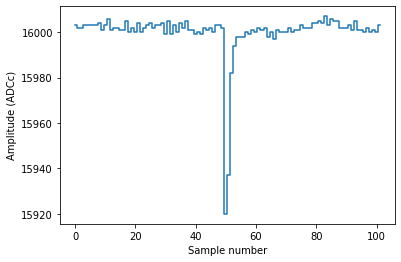

In [8]:
def plot_record(sample_r):
    plt.plot(sample_r['data'][:sample_r['length']], drawstyle='steps-mid')
    plt.xlabel("Sample number")
    plt.ylabel("Amplitude (ADCc)")
    
sample_r = rr[0]
plot_record(sample_r)

As you can see, this record contains a single PE pulse, straight as it comes off the DAQ. No operations have been done on it; we did not even subtract the baseline and flip the pulse. 

Each record is 110 samples long, but this digitizer pulse was only 102 samples long:

In [9]:
sample_r['pulse_length']

102

and thus the pulse has been zero-padded:

In [10]:
sample_r['data']

array([16003, 16002, 16002, 16003, 16003, 16003, 16003, 16003, 16004,
       16001, 16003, 16006, 16001, 16002, 16002, 16001, 16001, 16005,
       16000, 16002, 16000, 16004, 16000, 16002, 16003, 16004, 16002,
       16003, 16003, 16004, 15999, 16005, 15999, 16003, 16000, 16004,
       16002, 16005, 16001, 16001, 15999, 16000, 15999, 16002, 16001,
       16002, 16000, 16003, 16003, 16002, 15920, 15937, 15982, 15994,
       15998, 15998, 15998, 16000, 15999, 16001, 16000, 16002, 16001,
       16002, 15998, 16000, 15997, 16001, 16000, 16000, 16000, 16002,
       16000, 16001, 16001, 16003, 16002, 16002, 16002, 16004, 16004,
       16005, 16004, 16007, 16003, 16006, 16005, 16005, 16002, 16002,
       16002, 16003, 16001, 16005, 16001, 16001, 16000, 16002, 16000,
       16001, 16000, 16003,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int16)

Let's take care of the baseline and zero padding:

In [11]:
# Convert from raw_records to the records datatype, which has more fields.
# Without this we cannot baseline.
rr = strax.raw_to_records(rr)

# Subtract baseline and flip channel
strax.baseline(rr)

Now things look more reasonable:

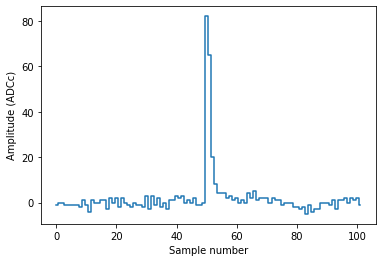

In [12]:
plot_record(rr[0])

### Pulse shape

Let's focus on channel 100:

In [13]:
r = rr[rr['channel'] == 100]

Here is the distribution of amplitudes in each sample. This is very roughly the mean pulse shape:

Text(0, 0.5, 'Amplitude (ADCc)')

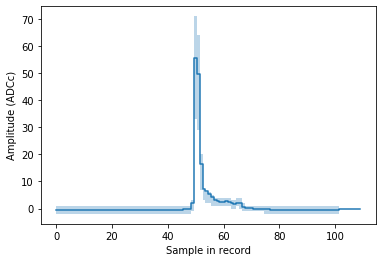

In [14]:
ns = np.arange(len(r[0]['data']))

plt.plot(ns, r['data'].mean(axis=0), drawstyle='steps-mid')
plt.fill_between(
    ns,
    np.percentile(r['data'], 25, axis=0),
    np.percentile(r['data'], 75, axis=0), 
    step='mid', alpha=0.3, linewidth=0)
plt.xlabel("Sample in record")
plt.ylabel("Amplitude (ADCc)")

You can clearly see we're dealing with single PEs here, and also see the infamous long PE pulse tail. For a serious pulse shape study you should of course first normalize the pulses.

## Gain calibration

Let's integrate between sample 40 and 70, to get the mean single-PE area. We have to add a small correction for the baseline, see [here](https://github.com/AxFoundation/strax/issues/2) for details. Usually this is done inside strax and you don't have to worry about it.

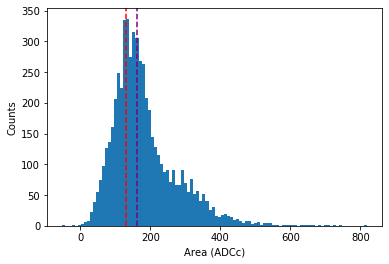

In [15]:
left, right = 40, 70
areas = r['data'][:,left:right].sum(axis=1)

# Small correction for baseline, see strax issue #2
areas += ((r['baseline'] % 1) * (right - left)).round().astype(np.int64)

# Hack to get ADC -> PE conversion factors. We'll make this better someday...
to_pe = st.get_single_plugin(run_id, 'peaklets').to_pe

plt.hist(areas, bins=100)
plt.xlabel("Area (ADCc)")
plt.ylabel("Counts")
plt.axvline(1/to_pe[100], color='r', linestyle='--')
plt.axvline(np.median(areas), color='purple', linestyle='--')

The purple line is an extremely bad gain estimate (the median area) of pulses, which nonetheless comes close for this PMT. It should be obvious this is a bad method: it takes no account of 2PE hits or the hitfinder efficiency at all.

The red line indicates where the 1 PE area should be according to the XENON1T gain calibration. Looks like the gain is, at least approximately, correct!

Let's do the same for all PMTs:

In [16]:
areas = rr['data'][:,40:70].sum(axis=1)
channels = rr['channel']

gain_ests = np.array([
    np.median(areas[channels == pmt]) 
    for pmt in tqdm(np.arange(248))])

 13%|█▎        | 33/248 [00:00<00:02, 79.23it/s]/home/aalbers/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aalbers/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 248/248 [00:03<00:00, 81.55it/s]


/home/aalbers/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


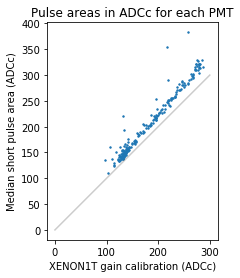

In [17]:
plt.scatter(1/to_pe, gain_ests, s=2)
plt.plot([0, 300], [0, 300], c='k', alpha=0.2)
plt.xlabel("XENON1T gain calibration (ADCc)")
plt.ylabel("Median short pulse area (ADCc)")
plt.title("Pulse areas in ADCc for each PMT")
plt.gca().set_aspect('equal')

As you can see, even this extremely basic method (median area of short pulses in 30sec of background data) gives a somewhat plausible gain estimate for most PMTs.